## mehdikaytoue, renomer le fichier suivie du numero de fichier

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/starcraft-2-player-prediction-challenge-2019.zip
../data/input/SAMPLE_SUBMISSION.CSV
../data/input/TEST.CSV
../data/input/TEST_LONG.CSV
../data/input/TRAIN.CSV
../data/input/TRAIN_LONG.CSV
../data/output/submission.csv
../data/output/charts/.png
../data/output/charts/v1.png
../data/output/charts/v1_historic_only.png
../data/output/charts/v2_historic_only.png
../data/output/charts/v3_historic_only.png
../data/output/charts/v4_historic_only.png


Important definitions

In [28]:
#To be sure that we get all the right keys
CSV_KEYS = ['id', 'class', 's', 'sBase', 'sMineral', 'order']
for i in range(10):
    CSV_KEYS.append('hotkey' + str(i))

#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

#Define Directories
OUTPUT = '../data/output'
OUTPUT_SUB = OUTPUT + '/submission.csv'
OUTPUT_CHARTS = OUTPUT + '/charts/'
INPUT = '../data/input'
INPUT_TRAIN = INPUT + '/TRAIN.CSV'
INPUT_TEST = INPUT + '/TEST.CSV'

#Define HISTORIC_KEYS
HISTORIC_KEYS = {'2':[], '3':[]}
for i in range(10):
    for j in range(10):
        HISTORIC_KEYS['2'].append( str(i) + str(j) )
        
for i in range(10):
    for j in range(10):
        for k in range(10):
            HISTORIC_KEYS['3'].append( str(i) + str(j) + str(k) )

Functions to get clean data

In [29]:
import csv
from collections import defaultdict

def zero_dict():
    new_dict = {}
    #Initialize to zero
    for i in CSV_KEYS:
        new_dict[i] = 0
    return new_dict

def get_train_data(csv_file=INPUT_TRAIN):
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []
        
        for row in cvs_reader:

            #Initialize to zero
            csv_dict = zero_dict()
            ord_representation = ''
            csv_dict['id'] = row[0]
            ids.append(row[0])
            csv_dict['class'] = CLASSES[row[1]]
            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    csv_dict[row[len(row)-i][:-1]] += 1/t
                    ord_representation += row[len(row)-i][-2:-1]
                    
                if 'Base' in row[len(row)-i] and t != 0:
                    csv_dict['sBase'] += 1/t
                    
                if 'Mineral' in row[len(row)-i] and t != 0:
                    csv_dict['sMineral'] += 1/t
                    
                if 's' == row[len(row)-i] and t != 0:
                    csv_dict['s'] += 1/t
                    
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            csv_dict['order'] = ord_representation
            data.append(csv_dict)
        return (data, ids)
    
def get_test_data(csv_file=INPUT_TEST):
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        
        for row in cvs_reader:

            #Initialize to zero
            csv_dict = zero_dict()
            ord_representation = ''
            
            csv_dict['class'] = CLASSES[row[0]]
            t = 0
            for i in range(1, len(row)-1):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    csv_dict[row[len(row)-i][:-1]] += 1/t
                    ord_representation += row[len(row)-i][-2:-1]
                
                if 'Base' in row[len(row)-i] and t != 0:
                    csv_dict['sBase'] += 1/t
                    
                if 'Mineral' in row[len(row)-i] and t != 0:
                    csv_dict['sMineral'] += 1/t
                    
                if 's' == row[len(row)-i] and t != 0:
                    csv_dict['s'] += 1/t
                    
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            csv_dict['order'] = ord_representation
            data.append(csv_dict)
        return data

# Generate different features

We are going to test five different combinations of features with KNN:
1. The number of times the player used a given sequence of 2 keys
2. The number of times the player used a given sequence of 3 keys
3. Combination of 1 with 2
4. Combination of 1 with 3

In [30]:
##Only sequence features
def generate_df_only_sequence(df=None, slice_size=2):
    historic_by_id = []
    window = slice_size-1

    for idx, _ in df['order'].items():
        historic_by_id.append(defaultdict(int))

    for idx, value in df['order'].items():
        for j in range(0, len(value)-window):
            #Data is in the same order as ids's list
            if slice_size == 2:
                sequence = str(value[j]) + str(value[j+window])
            elif slice_size == 3:
                sequence = str(value[j]) + str(value[j+window-1]) + str(value[j+window])
                
            historic_by_id[ idx ][ sequence ] += 1
            
    df_X = pd.DataFrame(historic_by_id, columns=HISTORIC_KEYS[ str(slice_size) ]) 
    return df_X

##Concat of basic and sequence features
def generate_df_with_sequence(df=None, slice_size=2):
    #Fusion boths data frames
    df_historic = generate_df_only_sequence(df, slice_size)
    df_X = pd.concat([df.drop(labels='order', axis=1), df_historic], axis=1, join='inner')
    return df_X



In [32]:
#0.
data, ids = get_train_data()
df_0 = pd.DataFrame(data, columns=CSV_KEYS) 
#1.
df_1 = generate_df_only_sequence(df=df_0, slice_size=2)
#2.
df_2 = generate_df_only_sequence(df=df_0, slice_size=3)
#3.
df_3 = generate_df_with_sequence(df=df_0, slice_size=2)
#4.
df_4 = generate_df_with_sequence(df=df_0, slice_size=3)

##Clean innecesary labels
df_3 = df_3.drop(columns=['id'])
df_4 = df_4.drop(columns=['id'])

In [33]:
from IPython.core import display as ICD
#Visualize
print('1.\n')
ICD.display(df_1.head(1))
print('\t-----------------------------------------------------------------------\n')
print('2.\n')
ICD.display(df_2.head(1))
print('\t-----------------------------------------------------------------------\n')
print('3.\n')
ICD.display(df_3.head(1))
print('\t-----------------------------------------------------------------------\n')
print('4.\n')
ICD.display(df_4.head(1))

1.



,00,01,02,03,04,05,06,07,08,09,...,90,91,92,93,94,95,96,97,98,99
0,1.0,4.0,4.0,4.0,2.0,25.0,2.0,NaN,NaN,4.0,...,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


	-----------------------------------------------------------------------

2.



,000,001,002,003,004,005,006,007,008,009,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


	-----------------------------------------------------------------------

3.



,class,s,sBase,sMineral,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,...,90,91,92,93,94,95,96,97,98,99
0,1,0.407251,0.039275,0.003021,0.027795,0.249547,0.134139,0.2429,0.1571,0.071299,...,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


	-----------------------------------------------------------------------

4.



,class,s,sBase,sMineral,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,...,990,991,992,993,994,995,996,997,998,999
0,1,0.407251,0.039275,0.003021,0.027795,0.249547,0.134139,0.2429,0.1571,0.071299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Stratify Sampling and Training KNN

Separate the data into train and valid, making sure that we have at least one instance of each class in both of the groups

In [34]:
def isStratified(y_valid=None, y_train=None):    
    counter = 0

    for i in y_valid:
        if i not in y_train:
            counter += 1

    return 0 == counter

Following the tutorial at: https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75

In [35]:
#Import the KNeighborsCLassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier
#Import metrics model to check the mean f1
from sklearn import metrics

def run_knn(X_train, y_train, y_valid,till=25):
    #Try running from k=1 through "till" and record testing accuracy
    k_range = range(1, till)
    scores = {}
    scores_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_valid)
        scores[k] = metrics.f1_score(y_valid, y_pred, average='micro')
        scores_list.append(scores[k])
    return (k_range, scores_list)

### Train and validate

In [36]:
from sklearn.model_selection import train_test_split

#Put all together to iterete
dfs = [df_1, df_2, df_3, df_4]
all_ranges = []
all_scores = []

for i in range(4):    
    X = dfs[i].fillna(0).values
    y = np.asarray(ids)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=ids)
    if not isStratified(y_valid, y_train):
        raise Exception("Not stratified sample")
    k_range, scores_list = run_knn(X_train, y_train, y_valid)
    all_ranges.append(k_range)
    all_scores.append(scores_list)

Visualize

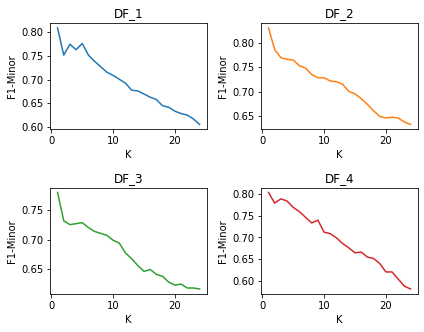

In [37]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(all_ranges[0], all_scores[0])
axs[0, 0].set_title('DF_1')
axs[0, 1].plot(all_ranges[1], all_scores[1], 'tab:orange')
axs[0, 1].set_title('DF_2')
axs[1, 0].plot(all_ranges[2], all_scores[2], 'tab:green')
axs[1, 0].set_title('DF_3')
axs[1, 1].plot(all_ranges[3], all_scores[3], 'tab:red')
axs[1, 1].set_title('DF_4')

for ax in axs.flat:
    ax.set(xlabel='K', ylabel='F1-Minor')
    
plt.subplots_adjust(top=0.98, bottom=0.04, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)

# Testing and Saving

In [40]:
X = dfs[0].fillna(0).values
y = np.asarray(ids)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
#Open TEST file and prepare TEST data
test_data = get_test_data()
#Testing
df_testX = generate_df_only_sequence(df=df_0, slice_size=2)
X_test = df_testX.fillna(0).values

y_predict = knn.predict(X_test)

In [74]:
#Save predictions
predictions_formatted = []

for i, value in enumerate(y_predict, 1):
    predictions_formatted.append([i, value])

df_predict = pd.DataFrame(predictions_formatted)
df_predict.head()

import os
#Remove if exists
if os.path.exists(OUTPUT_SUB):
    os.remove(OUTPUT_SUB)
df_predict.to_csv(OUTPUT_SUB, header=['RowId','prediction'], mode='w', index=False)